<p style="font-size:32px;text-align:center"> <b>Disneyland Reviews</b> </p>

# Data

The dataset includes 42000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.

Column Description:

1. Review_ID: unique id given to each review
2. Rating: ranging from 1 (unsatisfied) to 5 (satisfied)
3. Year_Month: when the reviewer visited the theme park
4. Reviewer_Location: country of origin of visitor
5. Review_Text: comments made by visitor
6. Disneyland_Branch: location of Disneyland Park


# Importing the Libraries and Data

In [2]:
#General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
sns.set()

import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tqdm import tqdm
tqdm.pandas()
import scikitplot as skplt

#Libraries to clean text
import re
from cleantext import clean
import os
from bs4 import BeautifulSoup

#Libraries for NLP
import nltk
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob, Word
import spacy
from PIL import Image

#Libraries for building models
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score
from prettytable import PrettyTable, MSWORD_FRIENDLY, DEFAULT

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('DisneylandReviews.csv')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
df.shape

(42656, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
df.nunique()

Review_ID            42636
Rating                   5
Year_Month             112
Reviewer_Location      162
Review_Text          42632
Branch                   3
dtype: int64

# Cleaning the Dataset

In [7]:
df.drop(df[df.Year_Month=='missing'].index, inplace=True)

In [8]:
df.shape

(40043, 6)

In [9]:
df.Branch.unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [10]:
df.Branch = df.Branch.apply(lambda x: re.sub('Disneyland_', '', x))

In [11]:
new = df.Year_Month.str.split('-', n=1, expand=True)
df['Year'] = new[0]
df['Month'] = new[1]
df.drop(columns=['Year_Month'], inplace=True)
df.head()

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


In [12]:
df.Year = df.Year.astype(int)
df.Month = df.Month.astype(int)

In [13]:
df.Month.unique()

array([ 4,  5,  3,  9,  1, 11, 12,  6,  2, 10,  8,  7])

In [14]:
def quarter(month):
    if month <=3:
        return 1
    elif month >3 and month <=6:
        return 2
    elif month >6 and month <=9:
        return 3
    else:
        return 4

In [15]:
# Use 'apply' with tqdm
df['Quarter'] = df.Month.progress_apply(quarter)

100%|██████████| 40043/40043 [00:00<00:00, 407799.22it/s]


In [16]:
df.drop_duplicates(subset='Review_Text', inplace=True, ignore_index=True)

In [17]:
df.drop_duplicates(subset='Review_ID', inplace=True, ignore_index=True)

In [18]:
df.shape

(40014, 8)

In [19]:
df.reset_index(drop=True)

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Quarter
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,2
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,2
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,2
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,2
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,2
...,...,...,...,...,...,...,...,...
40009,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Paris,2011,1,1
40010,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Paris,2011,1,1
40011,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Paris,2010,12,4
40012,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Paris,2010,12,4


In [20]:
df['Review_Length'] = df.Review_Text.apply(lambda x: len(x))

# Preprocessing the Text Data

In [21]:
#Modifying the NLTK stop words
stop_words = set(stopwords.words('english'))

#Remove words that are in NLTK stopwords list
not_stopwords = {'not', 'no', 'nor'} 
final_stop_words = list(set([word for word in stop_words if word not in not_stopwords]))
final_stop_words.sort()

print(final_stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than'

In [22]:
nlp = spacy.load('en_core_web_lg')

In [23]:
def preprocess_text1(x):
    
    #Convert the string to lowercase
    x = str(x).lower()
    
    #Replace the contracted words
    x = x.replace("’", "'").replace("won't", "will not").replace("can't", "can not").replace("n't", " not")\
        .replace("'s", "is").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("%", " percent ").replace("$", " dollar ").replace("€", " euro ").replace("'ll", " will")\
        .replace("n't", "not").replace("shan't", "shall not").replace("yr", "year")
    
    #Clean the strings
    x = re.sub('[^a-zA-Z0-9 ]', '', x)
    x = re.sub(' +', ' ', x)
    
    return x

In [24]:
df.Review_Text = df.Review_Text.progress_apply(preprocess_text1)

100%|██████████| 40014/40014 [00:05<00:00, 7533.19it/s] 


In [25]:
def preprocess_text2(x):
    
    #Lemmatization
    doc = nlp(x)
    x = ' '.join([token.lemma_ for token in doc])
    
    #Removing the stopwords
    x = ' '.join([token.text for token in doc if token.text not in final_stop_words])
    
    return x

In [26]:
df.Review_Text = df.Review_Text.progress_apply(preprocess_text2)

100%|██████████| 40014/40014 [31:46<00:00, 20.98it/s]  


In [27]:
def polarity(x):
    text = TextBlob(x)
    return text.sentiment.polarity

def subjectivity(x):
    text = TextBlob(x)
    return text.sentiment.subjectivity

In [28]:
df['Polarity'] = df.Review_Text.progress_apply(polarity)
df['Subjectivity'] = df.Review_Text.progress_apply(subjectivity)

100%|██████████| 40014/40014 [00:40<00:00, 985.04it/s] 


In [29]:
def review(rating):
    if rating <3:
        return 'Negative'
    elif rating==3:
        return 'Neutral'
    else:
        return 'Positive'

In [30]:
df['Review'] = df.Rating.progress_apply(review)

100%|██████████| 40014/40014 [00:00<00:00, 345077.55it/s]


In [31]:
df.tail()

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Quarter,Review_Length,Polarity,Subjectivity,Review
40009,92198076,4,United Kingdom,although pick prompt taxi driver nt sure time ...,Paris,2011,1,1,1574,0.050476,0.402169,Positive
40010,92061774,4,Germany,returned 4 days family trip disneyland two boy...,Paris,2011,1,1,3593,0.182696,0.392499,Positive
40011,91995748,1,United Kingdom,spent 20 dec 2010 disney park lunchtime attrac...,Paris,2010,12,4,2537,0.006901,0.457556,Negative
40012,91984642,2,United Kingdom,well really looking forward trip christmas per...,Paris,2010,12,4,1758,0.064015,0.438194,Negative
40013,91827418,5,United Kingdom,staying disney hotel make good use extra hours...,Paris,2010,9,3,512,0.115000,0.445000,Positive


# Exploratory Data Analysis

<AxesSubplot:>

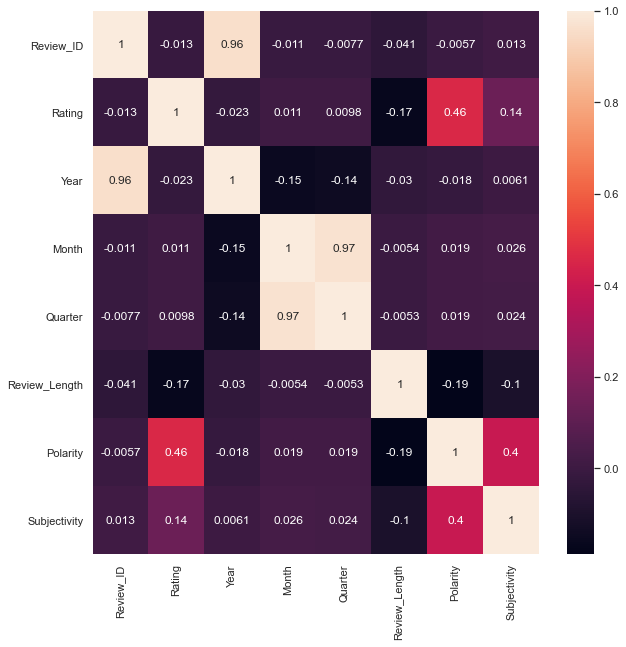

In [32]:
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True)

## Reviews by Years

Text(0.5, 1.0, 'Reviews per Year')

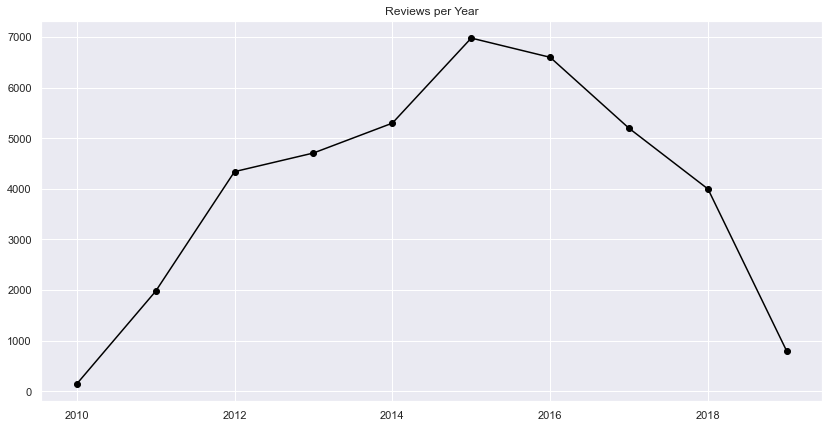

In [33]:
df1 = df.groupby(by='Year', as_index=False).agg({'Review_Length':'count'})
sns.set_style('darkgrid')
plt.figure(figsize=(14,7))
plt.plot(df1['Year'], df1['Review_Length'], marker='o', color='black')
plt.title('Reviews per Year')

Most number of reviews were written in **Year 2015.**

## Visits to Each Branches per Year

Text(0.5, 1.0, 'Visits to Each Branches per Year')

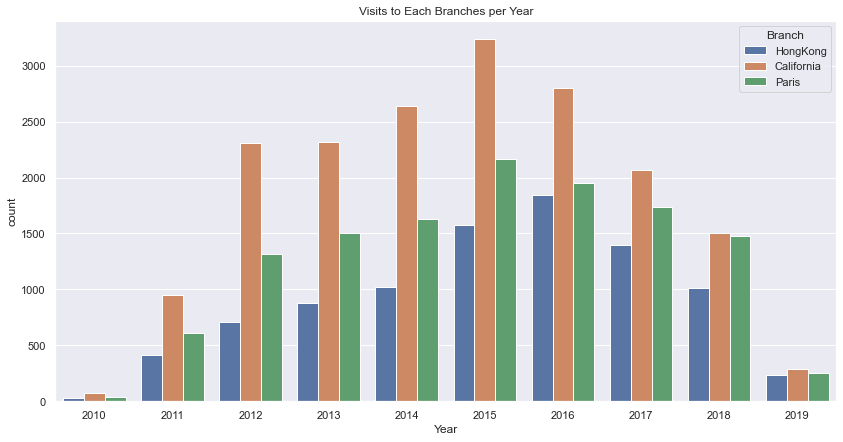

In [34]:
plt.figure(figsize=(14,7))
plots = sns.countplot(x='Year', data=df, hue='Branch')
plt.title('Visits to Each Branches per Year')

## Rating vs Quarter

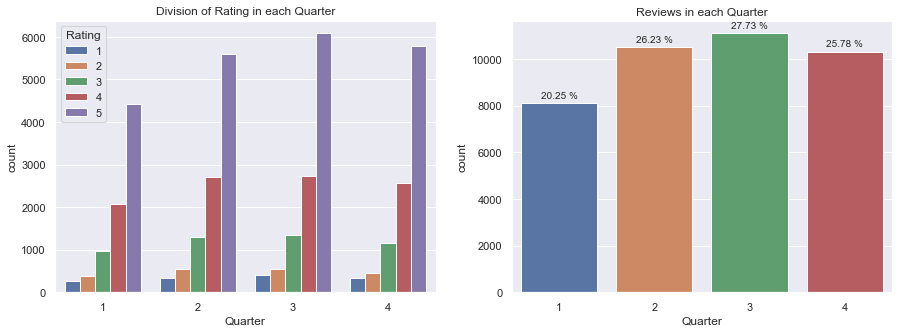

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
plots = sns.countplot(ax=axes[0],x='Quarter', data=df, hue='Rating')
axes[0].set_title('Division of Rating in each Quarter')

plots = sns.countplot(ax=axes[1],x='Quarter', data=df)
axes[1].set_title('Reviews in each Quarter')

for bar in plots.patches:
    plots.annotate(f'{round(bar.get_height()/len(df)*100,2)} %', xy=(bar.get_x() + bar.get_width() / 2,  
                   bar.get_height()), ha='center', va='center', size=10, xytext=(0, 8), textcoords='offset points')


Least number of reviews are given in **1st Quarter.**

## Average Rating by Country

In [36]:
df4 = df.groupby(by='Reviewer_Location', as_index=False).agg({'Rating':'mean'}).sort_values(by='Rating')
df4.style.background_gradient(subset=['Rating'])

,Reviewer_Location,Rating
3,Andorra,2.000000
147,Turks and Caicos Islands,2.000000
132,South Sudan,2.000000
136,Suriname,2.000000
39,Ecuador,2.333333
58,Haiti,3.000000
129,Solomon Islands,3.000000
107,Northern Mariana Islands,3.000000
36,Democratic Republic of the Congo,3.000000
128,Slovenia,3.000000


## Reviews by each Branch

Text(0.5, 1.0, 'Reviews by each Branch')

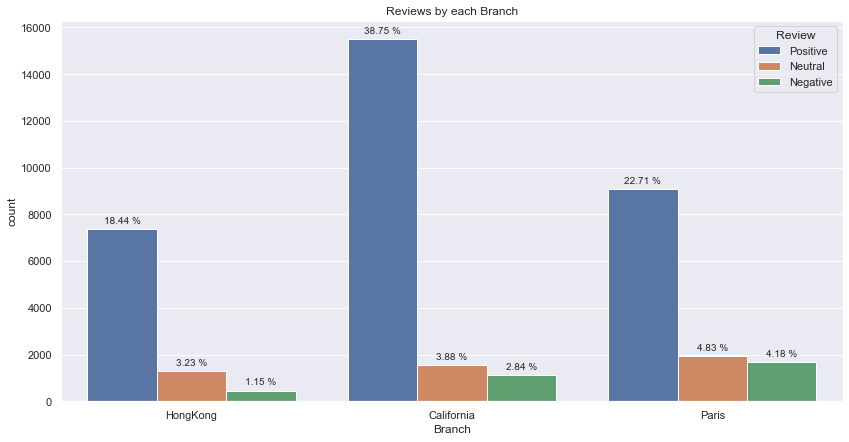

In [37]:
plt.figure(figsize=(14,7))
plots = sns.countplot(x='Branch', hue='Review', data=df)

for bar in plots.patches:
    plots.annotate(f'{round(bar.get_height()/len(df)*100,2)} %', xy=(bar.get_x() + bar.get_width() / 2,  
                   bar.get_height()), ha='center', va='center', size=10, xytext=(0, 8), textcoords='offset points')

plt.title('Reviews by each Branch')

## Most Occuring Words in the Corpus

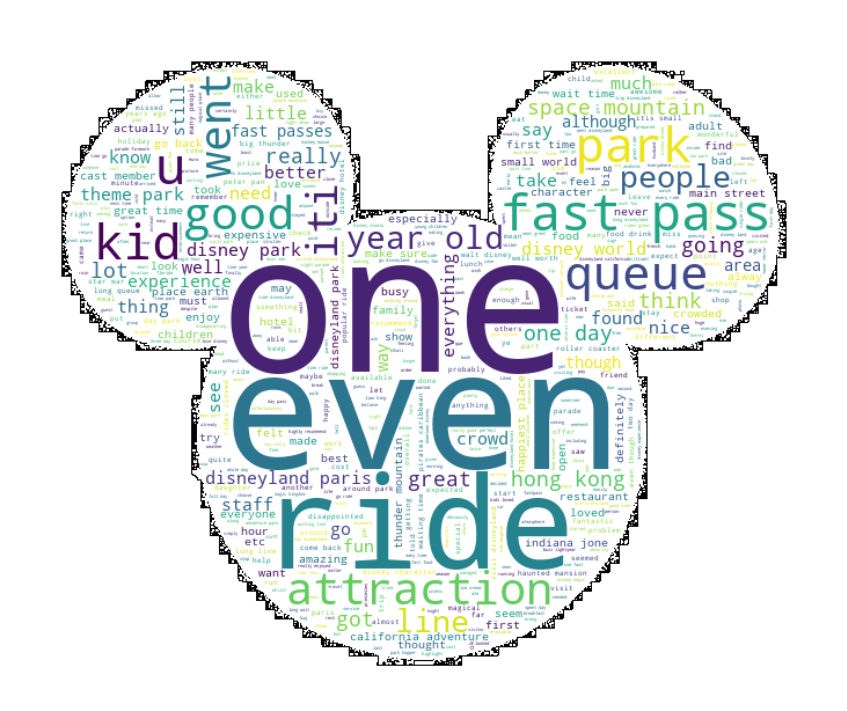

In [38]:
df['Review_Text']=df['Review_Text'].astype('str')
Reviews_Text = " ".join(txt for txt in df.Review_Text)
c_mask = np.array(Image.open("mickey mouse.jpg"))

wc = WordCloud(background_color='white', mask=c_mask, mode='RGB', width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='black')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Positive" Reviews

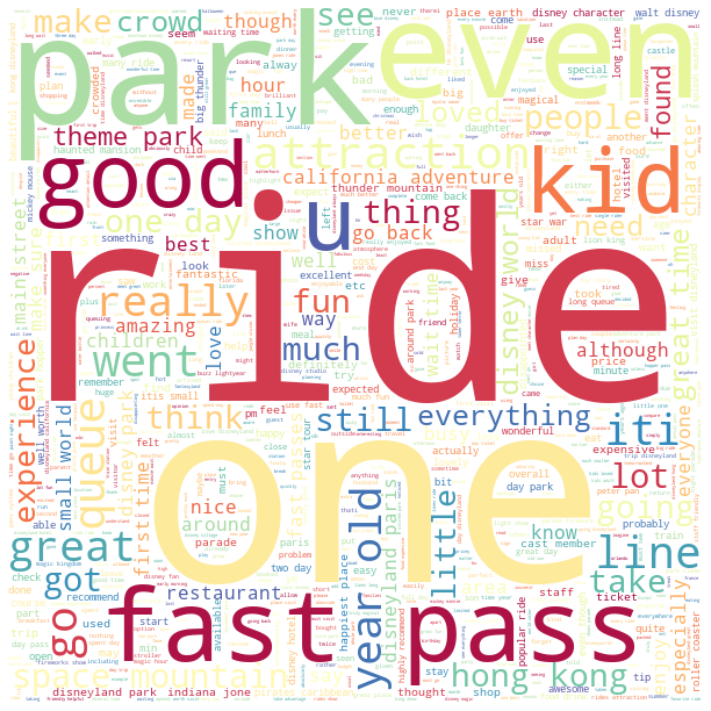

In [39]:
df_pos = df.loc[df['Review']=='Positive']
Reviews_Text = " ".join(insul for insul in df_pos.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Negative" Reviews

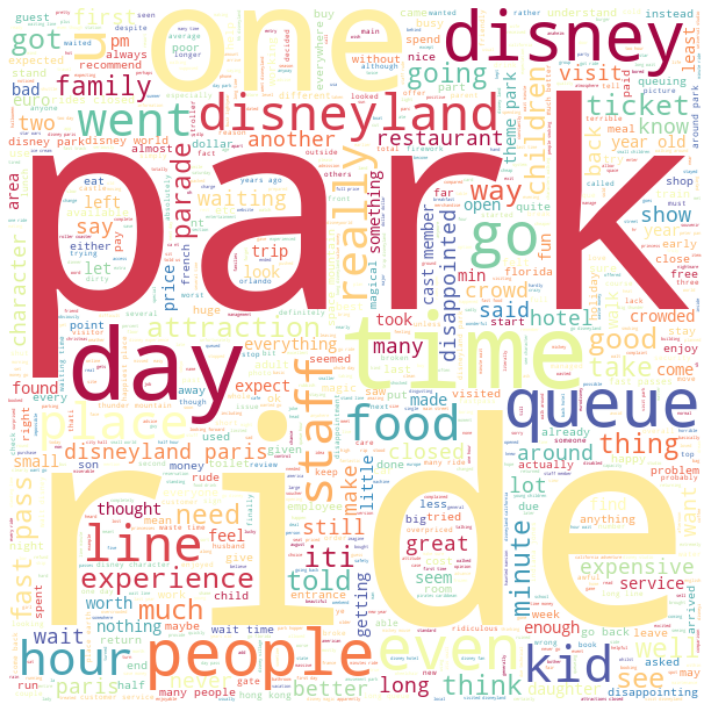

In [40]:
df_neg = df.loc[df['Review']=='Negative']
Reviews_Text = " ".join(insul for insul in df_neg.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Neutral" Reviews

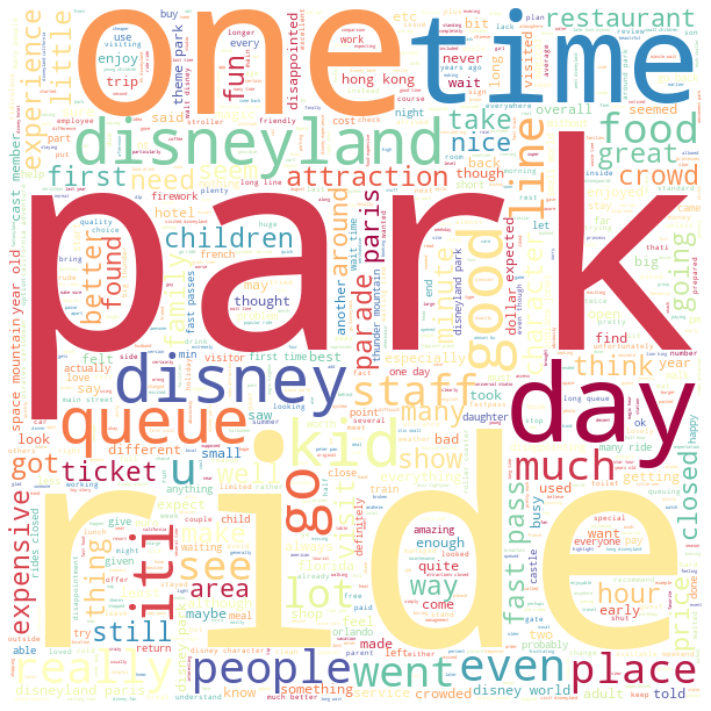

In [41]:
df_neu = df.loc[df['Review']=='Neutral']
Reviews_Text = " ".join(insul for insul in df_neu.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

# Machine Learning Models

## Splitting the dataset

Splitting the dataset into train, cv and test in 64:16:20.

In [42]:
df.drop(columns=['Quarter', 'Review_ID', 'Rating'], inplace=True)
df.head(1)

In [44]:
y = df['Review']
x = df.drop(columns=['Review'])
x.head(1)

,Reviewer_Location,Review_Text,Branch,Year,Month,Review_Length,Polarity,Subjectivity
0,Australia,ever disneyland anywhere find disneyland hong ...,HongKong,2019,4,329,0.226852,0.531481


In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [46]:
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(25608, 8)
(6403, 8)
(8003, 8)


In [47]:
y_train.value_counts()

Positive    20460
Neutral      3058
Negative     2090
Name: Review, dtype: int64

## Encoding and Normalization of Columns

In [48]:
le = LabelEncoder()
le.fit(y_train.values)

y_train = le.transform(y_train.values)
y_cv = le.transform(y_cv.values)
y_test = le.transform(y_test.values)

In [49]:
vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
vec.fit(x_train['Review_Text'].values)
print(x_train.shape, y_train.shape)

x_train_text = vec.transform(x_train['Review_Text'].values)
x_cv_text = vec.transform(x_cv['Review_Text'].values)
x_test_text = vec.transform(x_test['Review_Text'].values)

print('After vectorization...')
print(x_train_text.shape, y_train.shape)
print(x_cv_text.shape, y_cv.shape)
print(x_test_text.shape, y_test.shape)

(25608, 8) (25608,)
After vectorization...
(25608, 10000) (25608,)
(6403, 10000) (6403,)
(8003, 10000) (8003,)


In [50]:
ce = BinaryEncoder(cols=['Reviewer_Location'], return_df=False)
ce.fit(x_train)
print(x_train.shape, y_train.shape)

x_train_loc = ce.transform(x_train)
x_cv_loc = ce.transform(x_cv)
x_test_loc = ce.transform(x_test)

print('After vectorization...')
print(x_train_loc.shape, y_train.shape)
print(x_cv_loc.shape, y_cv.shape)
print(x_test_loc.shape, y_test.shape)

(25608, 8) (25608,)
After vectorization...
(25608, 16) (25608,)
(6403, 16) (6403,)
(8003, 16) (8003,)


In [51]:
x_train_loc = x_train_loc[ :, 0:9]
x_cv_loc = x_cv_loc[ :, 0:9]
x_test_loc = x_test_loc[ :, 0:9]

print(x_train_loc.shape, y_train.shape)
print(x_cv_loc.shape, y_cv.shape)
print(x_test_loc.shape, y_test.shape)

(25608, 9) (25608,)
(6403, 9) (6403,)
(8003, 9) (8003,)


In [52]:
ohe = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), ['Branch']), ('sca', MinMaxScaler(), ['Year', 'Month', 'Review_Length', 'Polarity', 'Subjectivity'])], remainder='drop')
ohe.fit(x_train)
print(x_train.shape, y_train.shape)

x_train_ohe = ohe.transform(x_train)
x_cv_ohe = ohe.transform(x_cv)
x_test_ohe = ohe.transform(x_test)

print('After vectorization...')
print(x_train_ohe.shape, y_train.shape)
print(x_cv_ohe.shape, y_cv.shape)
print(x_test_ohe.shape, y_test.shape)

(25608, 8) (25608,)
After vectorization...
(25608, 8) (25608,)
(6403, 8) (6403,)
(8003, 8) (8003,)


### Combining all encoded and normalized data

In [53]:
x_tr = hstack((x_train_text.astype(np.float), x_train_loc.astype(np.float), x_train_ohe.astype(np.float))).tocsr()
x_cv = hstack((x_cv_text.astype(np.float), x_cv_loc.astype(np.float), x_cv_ohe.astype(np.float))).tocsr()
x_te = hstack((x_test_text.astype(np.float), x_test_loc.astype(np.float), x_test_ohe.astype(np.float))).tocsr()

print("Final Data Matrix Shape is........")
print(x_tr.shape,y_train.shape)
print(x_cv.shape,y_cv.shape)
print(x_te.shape,y_test.shape)

Final Data Matrix Shape is........
(25608, 10017) (25608,)
(6403, 10017) (6403,)
(8003, 10017) (8003,)


In [54]:
smt = SMOTE(random_state=42, n_jobs=-1)
x_tr, y_train = smt.fit_resample(x_tr, y_train)

In [59]:
pd.DataFrame(y_train).value_counts()

0    20460
1    20460
2    20460
dtype: int64

In [60]:
def cnf_matrix(true_y, pred_y):

    # Confusion Matrix
    cf_matrix = confusion_matrix(true_y, pred_y)
    print('-'*40, 'Confusion Matrix', '-'*40)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="YlGnBu", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Precision Matrix
    pc_matrix =(cf_matrix/cf_matrix.sum(axis=0))
    print("-"*40, "Precision matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(5,5))
    sns.heatmap(pc_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Recall Matrix
    rl_matrix =(((cf_matrix.T)/(cf_matrix.sum(axis=1))).T)
    print("-"*40, "Recall matrix (Row sum=1)", "-"*40)
    plt.figure(figsize=(5,5))
    sns.heatmap(rl_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')

## Random Model and its Performance

Log loss on Cross Validation Data using Random Model 1.319665593607487
Log loss on Test Data using Random Model 1.3440388088291384
ROC-AUC Score on Cross Validation Data using Random Model 0.5108874915287381
ROC-AUC Score on Test Data using Random Model 0.49856257416409927


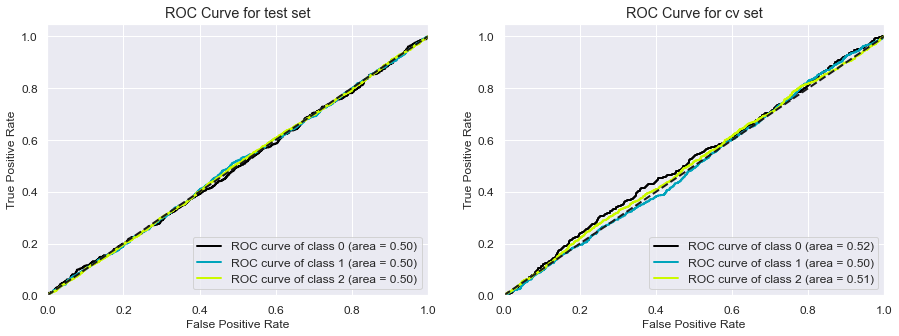

---------------------------------------- Confusion Matrix ----------------------------------------


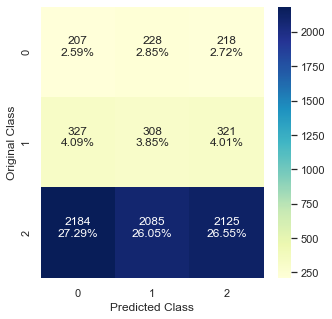

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


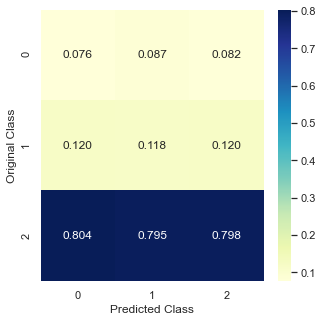

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


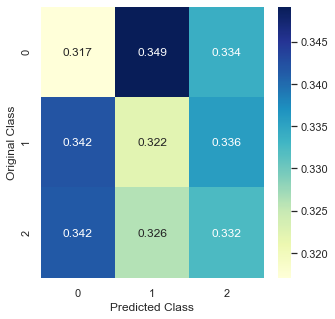

In [61]:
test_data_len = x_te.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,3))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,3)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])



# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,3))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,3)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])


predicted_y = np.argmax(test_predicted_y, axis=1)
predicted_cv = np.argmax(cv_predicted_y, axis=1)

ll_rm_cv = log_loss(y_cv,cv_predicted_y, eps=1e-15)
roc_rm_cv = roc_auc_score(y_cv, cv_predicted_y, multi_class='ovr')
ll_rm_te = log_loss(y_test,test_predicted_y, eps=1e-15)
roc_rm_te = roc_auc_score(y_test, test_predicted_y, multi_class='ovr')

print("Log loss on Cross Validation Data using Random Model",ll_rm_cv)
print("Log loss on Test Data using Random Model",ll_rm_te)
print("ROC-AUC Score on Cross Validation Data using Random Model",roc_rm_cv)
print("ROC-AUC Score on Test Data using Random Model",roc_rm_te)

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, test_predicted_y, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, cv_predicted_y, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, predicted_y)

## Logistic Regression

### Hyperparameter Tuning

In [62]:
alpha = [10 ** x for x in range(-6, 4)]
params = {'alpha':alpha}
clf1 = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
r_search = RandomizedSearchCV(clf1, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1,
                                           random_state=42),
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   random_state=42, return_train_score=True)

In [63]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'alpha': 1e-06} at which the score is 0.9618768328445746


### Training the Model

In [64]:
clf1 = SGDClassifier(loss='log', n_jobs=-1, random_state=42, **r_search.best_params_)
clf1.fit(x_tr, y_train)
cal_clf1 = CalibratedClassifierCV(clf1, cv='prefit')
cal_clf1.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-06, loss='log',
                                                    n_jobs=-1,
                                                    random_state=42),
                       cv='prefit')

In [65]:
y_pred_tr = cal_clf1.predict(x_tr)
y_prob_tr = cal_clf1.predict_proba(x_tr)
y_pred_cv = cal_clf1.predict(x_cv)
y_prob_cv = cal_clf1.predict_proba(x_cv)
y_pred = cal_clf1.predict(x_te)
y_prob = cal_clf1.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Logistic Regression 0.20798406426977434
Log loss on Cross Validation Data using Logistic Regression 0.8521398318196816
Log loss on Test Data using Logistic Regression 0.8509303994522576
ROC-AUC Score on Train Data using Logistic Regression 0.9999922473879526
ROC-AUC Score on Cross Validation Data using Logistic Regression 0.7995331977353973
ROC-AUC Score on Test Data using Logistic Regression 0.7979908015292644


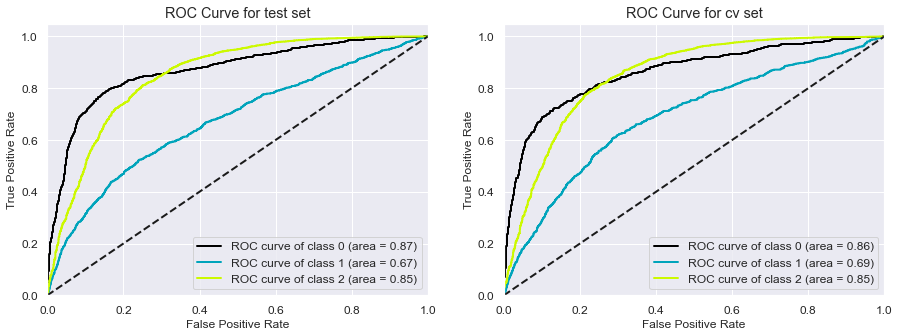

---------------------------------------- Confusion Matrix ----------------------------------------


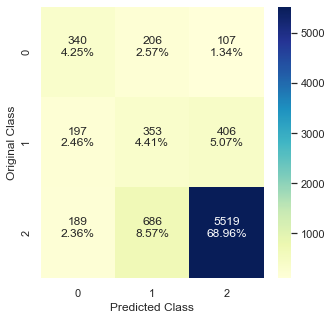

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


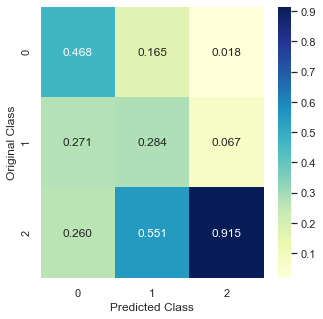

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


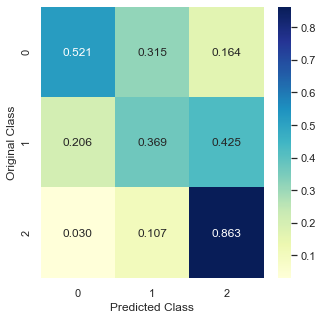

In [66]:
ll_lg_tr = log_loss(y_train, y_prob_tr, labels=cal_clf1.classes_, eps=1e-15)
ll_lg_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf1.classes_, eps=1e-15)
ll_lg_te = log_loss(y_test, y_prob, labels=cal_clf1.classes_,  eps=1e-15)
roc_lg_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_lg_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_lg_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Logistic Regression",ll_lg_tr)
print("Log loss on Cross Validation Data using Logistic Regression",ll_lg_cv)
print("Log loss on Test Data using Logistic Regression",ll_lg_te)
print("ROC-AUC Score on Train Data using Logistic Regression",roc_lg_tr)
print("ROC-AUC Score on Cross Validation Data using Logistic Regression",roc_lg_cv)
print("ROC-AUC Score on Test Data using Logistic Regression",roc_lg_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Naive Bayes

### Hyperparameter Tuning

In [67]:
alpha = [10 ** x for x in range(-6, 3)]
params = {'alpha':alpha}
clf2 = MultinomialNB()
r_search = RandomizedSearchCV(clf2, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=MultinomialNB(),
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100]},
                   random_state=42, return_train_score=True)

In [68]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'alpha': 1e-06} at which the score is 0.8572499185402412


### Training the model

In [69]:
clf2 = MultinomialNB(**r_search.best_params_)
clf2.fit(x_tr, y_train)
cal_clf2 = CalibratedClassifierCV(clf2, cv='prefit')
cal_clf2.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1e-06), cv='prefit')

In [70]:
y_pred_tr = cal_clf2.predict(x_tr)
y_prob_tr = cal_clf2.predict_proba(x_tr)
y_pred_cv = cal_clf2.predict(x_cv)
y_prob_cv = cal_clf2.predict_proba(x_cv)
y_pred = cal_clf2.predict(x_te)
y_prob = cal_clf2.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Naive Bayes 0.41710365038198816
Log loss on Cross Validation Data using Naive Bayes 0.6121931791698142
Log loss on Test Data using Naive Bayes 0.6249828250371686
ROC-AUC Score on Train Data using Naive Bayes 0.9568190039804599
ROC-AUC Score on Cross Validation Data using Naive Bayes 0.8333013678706881
ROC-AUC Score on Test Data using Naive Bayes 0.8321490449365267


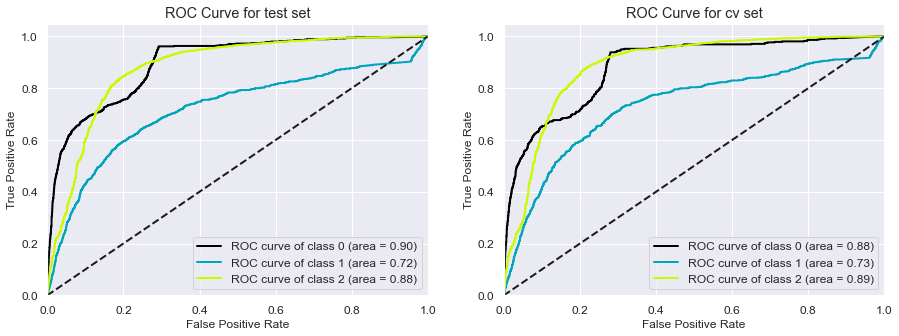

---------------------------------------- Confusion Matrix ----------------------------------------


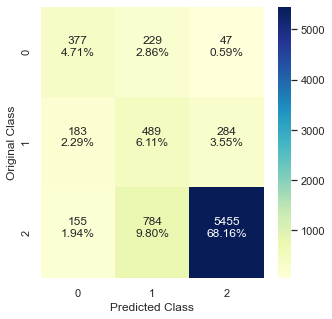

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


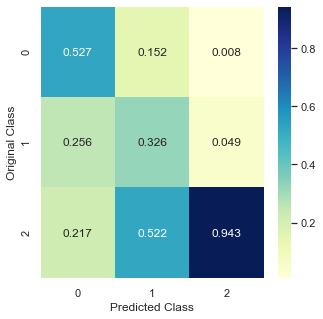

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


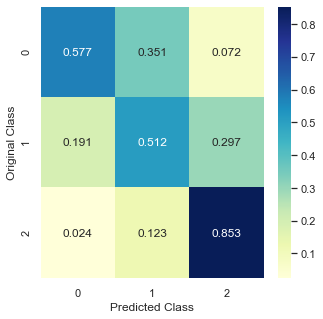

In [71]:
ll_nb_tr = log_loss(y_train, y_prob_tr, labels=cal_clf2.classes_, eps=1e-15)
ll_nb_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf2.classes_, eps=1e-15)
ll_nb_te = log_loss(y_test, y_prob, labels=cal_clf2.classes_, eps=1e-15)
roc_nb_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_nb_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_nb_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Naive Bayes",ll_nb_tr)
print("Log loss on Cross Validation Data using Naive Bayes",ll_nb_cv)
print("Log loss on Test Data using Naive Bayes",ll_nb_te)
print("ROC-AUC Score on Train Data using Naive Bayes",roc_nb_tr)
print("ROC-AUC Score on Cross Validation Data using Naive Bayes",roc_nb_cv)
print("ROC-AUC Score on Test Data using Naive Bayes",roc_nb_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Support Vector Machines

### Hyperparameter Tuning

In [72]:
alpha = [10 ** x for x in range(-6, 4)]
params = {'alpha':alpha}
clf3 = SGDClassifier(loss='hinge', n_jobs=-1, random_state=42)
r_search = RandomizedSearchCV(clf3, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=SGDClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   random_state=42, return_train_score=True)

In [73]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'alpha': 1e-05} at which the score is 0.9600195503421312


### Training the model

In [74]:
clf3 = SGDClassifier(loss='hinge', n_jobs=-1, random_state=42, **r_search.best_params_)
clf3.fit(x_tr, y_train)
cal_clf3 = CalibratedClassifierCV(clf3, cv='prefit')
cal_clf3.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, n_jobs=-1,
                                                    random_state=42),
                       cv='prefit')

In [75]:
y_pred_tr = cal_clf3.predict(x_tr)
y_prob_tr = cal_clf3.predict_proba(x_tr)
y_pred_cv = cal_clf3.predict(x_cv)
y_prob_cv = cal_clf3.predict_proba(x_cv)
y_pred = cal_clf3.predict(x_te)
y_prob = cal_clf3.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using SVM 0.21754905370968755
Log loss on Cross Validation Data using SVM 0.8445831059604048
Log loss on Test Data using SVM 0.8543078587624832
ROC-AUC Score on Train Data using SVM 0.9997811240777849
ROC-AUC Score on Cross Validation Data using SVM 0.7976338636753972
ROC-AUC Score on Test Data using SVM 0.796164967867549


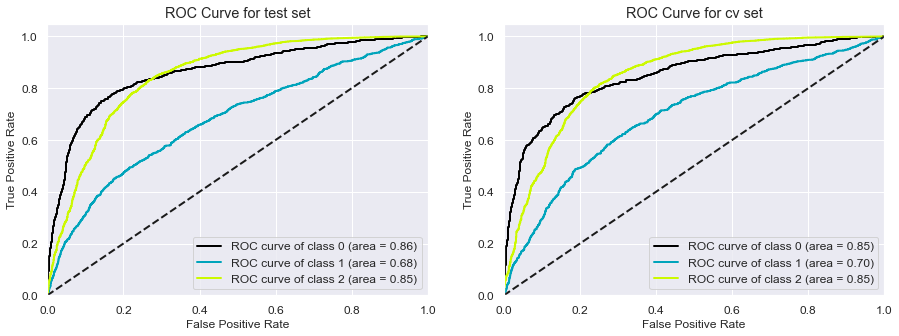

---------------------------------------- Confusion Matrix ----------------------------------------


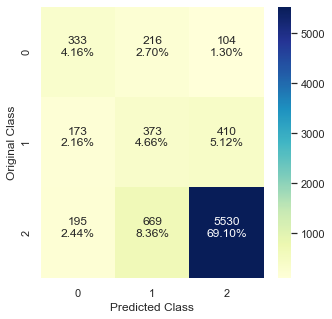

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


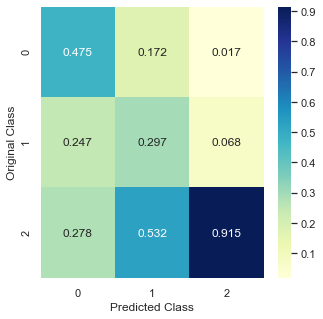

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


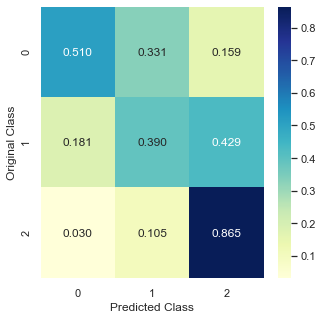

In [76]:
ll_svm_tr = log_loss(y_train, y_prob_tr, labels=cal_clf3.classes_, eps=1e-15)
ll_svm_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf3.classes_, eps=1e-15)
ll_svm_te = log_loss(y_test, y_prob, labels=cal_clf3.classes_, eps=1e-15)
roc_svm_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_svm_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_svm_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using SVM",ll_svm_tr)
print("Log loss on Cross Validation Data using SVM",ll_svm_cv)
print("Log loss on Test Data using SVM",ll_svm_te)
print("ROC-AUC Score on Train Data using SVM",roc_svm_tr)
print("ROC-AUC Score on Cross Validation Data using SVM",roc_svm_cv)
print("ROC-AUC Score on Test Data using SVM",roc_svm_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Decision Tress

### Hyperparameter Tuning

In [77]:
# Number of features to consider at every split
max_features = ['auto', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
params = { 'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}
clf4 = DecisionTreeClassifier(random_state=42)
r_search = RandomizedSearchCV(clf4, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, return_train_score=True)

In [78]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 60} at which the score is 0.8359563375692408


### Training the model

In [79]:
clf4 = DecisionTreeClassifier(**r_search.best_params_)
clf4.fit(x_tr, y_train)
cal_clf4 = CalibratedClassifierCV(clf4, cv='prefit')
cal_clf4.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=60,
                                                             min_samples_split=5),
                       cv='prefit')

In [80]:
y_pred_tr = cal_clf4.predict(x_tr)
y_prob_tr = cal_clf4.predict_proba(x_tr)
y_pred_cv = cal_clf4.predict(x_cv)
y_prob_cv = cal_clf4.predict_proba(x_cv)
y_pred = cal_clf4.predict(x_te)
y_prob = cal_clf4.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Decision Trees 0.05601751717145695
Log loss on Cross Validation Data using Decision Trees 1.3294215851137205
Log loss on Test Data using Decision Trees 1.3268730022334785
ROC-AUC Score on Train Data using Decision Trees 0.9987200701079474
ROC-AUC Score on Cross Validation Data using Decision Trees 0.5659346204953734
ROC-AUC Score on Test Data using Decision Trees 0.5610339048724208


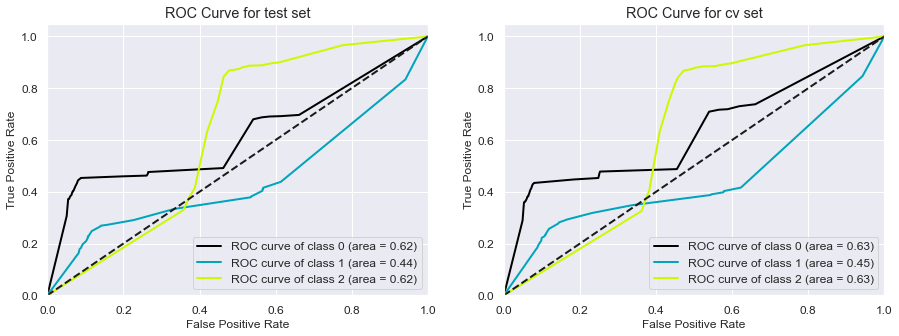

---------------------------------------- Confusion Matrix ----------------------------------------


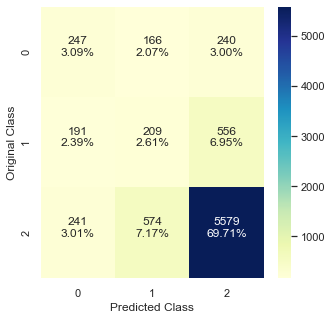

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


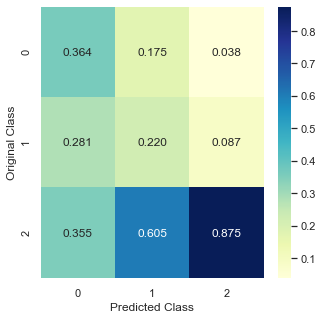

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


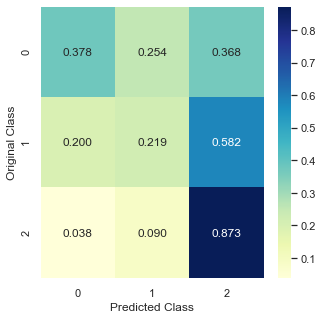

In [81]:
ll_dt_tr = log_loss(y_train, y_prob_tr, labels=cal_clf4.classes_, eps=1e-15)
ll_dt_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf4.classes_, eps=1e-15)
ll_dt_te = log_loss(y_test, y_prob, labels=cal_clf4.classes_, eps=1e-15)
roc_dt_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_dt_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_dt_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Decision Trees",ll_dt_tr)
print("Log loss on Cross Validation Data using Decision Trees",ll_dt_cv)
print("Log loss on Test Data using Decision Trees",ll_dt_te)
print("ROC-AUC Score on Train Data using Decision Trees",roc_dt_tr)
print("ROC-AUC Score on Cross Validation Data using Decision Trees",roc_dt_cv)
print("ROC-AUC Score on Test Data using Decision Trees",roc_dt_te)

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Stacking Classifier

### Training the model

In [82]:
estimators = [('nb', clf2), ('svc', clf3), ('dt',  clf4)]

scl = StackingClassifier(estimators=estimators, final_estimator=clf1, n_jobs=-1)
scl.fit(x_tr, y_train)
cal_clf = CalibratedClassifierCV(scl, cv='prefit')
cal_clf.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=StackingClassifier(estimators=[('nb',
                                                                      MultinomialNB(alpha=1e-06)),
                                                                     ('svc',
                                                                      SGDClassifier(alpha=1e-05,
                                                                                    n_jobs=-1,
                                                                                    random_state=42)),
                                                                     ('dt',
                                                                      DecisionTreeClassifier(max_depth=60,
                                                                                             min_samples_split=5))],
                                                         final_estimator=SGDClassifier(alpha=1e-06,
                                                     

In [83]:
y_pred_tr = cal_clf.predict(x_tr)
y_prob_tr = cal_clf.predict_proba(x_tr)
y_pred_cv = cal_clf.predict(x_cv)
y_prob_cv = cal_clf.predict_proba(x_cv)
y_pred = cal_clf.predict(x_te)
y_prob = cal_clf.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Stacking Classifier 0.10389665108582152
Log loss on Cross Validation Data using Stacking Classifier 0.7714254769256574
Log loss on Test Data using Stacking Classifier 0.7783718390660789
ROC-AUC Score on Train Data using Stacking Classifier 0.9999374017983893
ROC-AUC Score on Cross Validation Data using Stacking Classifier 0.8277077076348575
ROC-AUC Score on Test Data using Stacking Classifier 0.8258347575402012


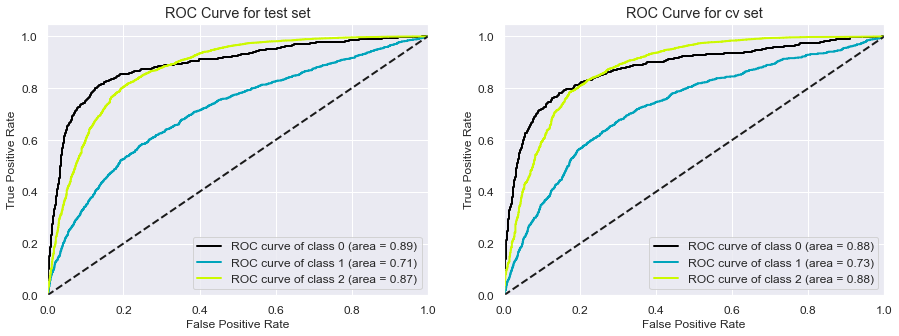

---------------------------------------- Confusion Matrix ----------------------------------------


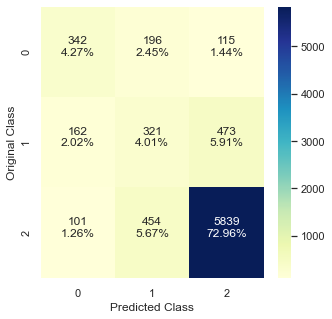

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


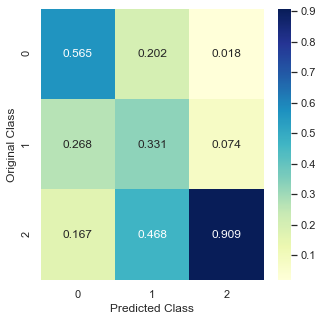

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


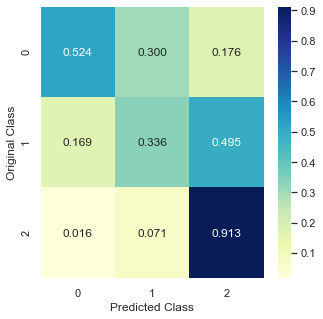

In [84]:
ll_sc_tr = log_loss(y_train, y_prob_tr, labels=cal_clf.classes_, eps=1e-15)
ll_sc_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf.classes_, eps=1e-15)
ll_sc_te = log_loss(y_test, y_prob, labels=cal_clf.classes_, eps=1e-15)
roc_sc_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_sc_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_sc_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Stacking Classifier",ll_sc_tr)
print("Log loss on Cross Validation Data using Stacking Classifier",ll_sc_cv)
print("Log loss on Test Data using Stacking Classifier",ll_sc_te)
print("ROC-AUC Score on Train Data using Stacking Classifier",roc_sc_tr)
print("ROC-AUC Score on Cross Validation Data using Stacking Classifier",roc_sc_cv)
print("ROC-AUC Score on Test Data using Stacking Classifier",roc_sc_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

# Summary of Result

In [85]:
table = PrettyTable()
table.field_names = ['Model', 'Train Log Loss', 'CV Log Loss', 'Test Log Loss', 'Train ROC-AUC', 'CV ROC-AUC', 'Test ROC-AUC']
table.add_rows([['Random Model', 'NA', round(ll_rm_cv,2), round(ll_rm_te,2), 'NA', round(roc_rm_cv,2), round(roc_rm_te,2)],
                ['Logistic Regression', round(ll_lg_tr,2), round(ll_lg_cv,2), round(ll_lg_te,2), round(roc_lg_tr,2), round(roc_lg_cv,2), round(roc_lg_te,2)],
                ['Naive Bayes', round(ll_nb_tr,2), round(ll_nb_cv,2), round(ll_nb_te,2), round(roc_nb_tr,2), round(roc_nb_cv,2), round(roc_nb_te,2)],
                ['SVM', round(ll_svm_tr,2), round(ll_svm_cv,2), round(ll_svm_te,2), round(roc_svm_tr,2), round(roc_svm_cv,2), round(roc_svm_te,2)],
                ['Decision Trees', round(ll_dt_tr,2), round(ll_dt_cv,2), round(ll_dt_te,2), round(roc_dt_tr,2), round(roc_dt_cv,2), round(roc_dt_te,2)],
                ['Stacking Classifier', round(ll_sc_tr,2), round(ll_sc_cv,2), round(ll_sc_te,2), round(roc_sc_tr,2), round(roc_sc_cv,2), round(roc_sc_te,2)]])

In [86]:
print('-'*47, 'BOW Vectorization', '-'*47)
table.set_style(DEFAULT)
print(table)

----------------------------------------------- BOW Vectorization -----------------------------------------------
+---------------------+----------------+-------------+---------------+---------------+------------+--------------+
|        Model        | Train Log Loss | CV Log Loss | Test Log Loss | Train ROC-AUC | CV ROC-AUC | Test ROC-AUC |
+---------------------+----------------+-------------+---------------+---------------+------------+--------------+
|     Random Model    |       NA       |     1.32    |      1.34     |       NA      |    0.51    |     0.5      |
| Logistic Regression |      0.21      |     0.85    |      0.85     |      1.0      |    0.8     |     0.8      |
|     Naive Bayes     |      0.42      |     0.61    |      0.62     |      0.96     |    0.83    |     0.83     |
|         SVM         |      0.22      |     0.84    |      0.85     |      1.0      |    0.8     |     0.8      |
|    Decision Trees   |      0.06      |     1.33    |      1.33     |      1.0  

So our best model is **Naive Bayes with a ROC-AUC Score of 0.86 and log loss of 0.63**